# TMEM256-FLAG qAP-MS example data analysis

This Jupyter notebok is part of a book chapter demonstrating the data analysis for mass spectrometry-based analysis of mitochondrial protein translocation mutants and interactome studies.
Data analysis relies on the autoprot software available at https://github.com/ag-warscheid/autoprot.

Author: Julian Bender, Warscheid Lab, Chair of Biochemistry II, University of Würzburg

In [1]:
import re

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

from autoprot_dev import analysis as ana
from autoprot_dev import preprocessing as pp
from autoprot_dev import visualization as vis

Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.7-2)

Scalable Robust Estimators with High Breakdown Point for
Incomplete Data (version 0.4-15)

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocManager
Bioconductor version '3.16' is out-of-date; the current release version '3.18'
  is available with R version '4.3'; see https://bioconductor.org/install
Loading required package: devtools
Loading required package: usethis

Attaching package: ‘devtools’

The following object is m

## Import and cleaning of proteinGroups.txt

The MaxQuant results files are parsed and reverse as well as potential contaminant entries are removed.
The additional column "Gene names first" that is eventually added, serves for the annotatin of the final volcano plot.

In [2]:
# parse the results file
pg = pp.read_csv("../MitoCop_q-AP-MS_proteinGroups.txt")
# remove reverse and potential contaminant entries
pg = pp.cleaning(pg, file="proteinGroups.txt")
# generate column for volcano plot annotation
pg["Gene names first"] = pg["Gene names"].str.split(";").str[0]

2307 rows before filter operation.
2307 rows after filter operation.


In [3]:
# select the ratio columns from the proteinGroups dataframe
ratio_cols = pg.filter(regex="Ratio H/L TMEM").columns.tolist()
ratio_cols

['Ratio H/L TMEM256_1',
 'Ratio H/L TMEM256_2',
 'Ratio H/L TMEM256_3',
 'Ratio H/L TMEM256_4']

In [4]:
# log transform the ratio columns.
# the invert kwarg indicates which replicates are label switches (i.e. must be multiplied with -1 to get the correct ratio)
pg, log_ratio_cols = pp.log(pg, ratio_cols, invert=(1, 1, -1, -1), return_cols=True)

As a control for the correct inversion of ratio columns, we plot the ratios of all proteins and highlight the bait protein TMEM256 and its close interactor TIMM50.
The log ratio of these two proteins should be positive if we correctly inverted the ratios.

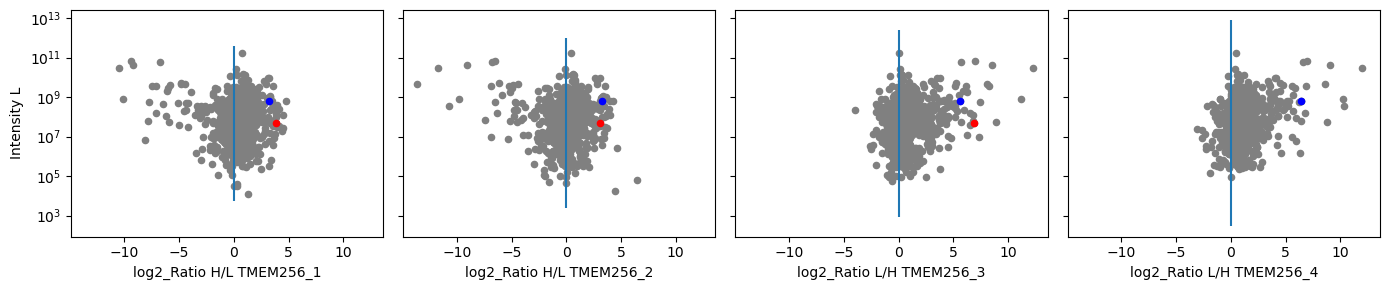

In [5]:
# figure object for plotting
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(14, 3), sharey=True, sharex=True)

# plot every replicate on a separate subplot
for ax, ratio in zip(axs, log_ratio_cols):
    pg.plot(
        kind="scatter",
        ax=ax,
        x=ratio,
        y="Intensity L",
        color="grey",
        logy=True,
    )
    pg[pg["Gene names"].str.contains("TMEM256", na=False)].plot(
        kind="scatter", ax=ax, x=ratio, y="Intensity L", color="red", logy=True
    )

    pg[pg["Gene names"].str.contains("TIMM50", na=False)].plot(
        kind="scatter", ax=ax, x=ratio, y="Intensity L", color="blue", logy=True
    )

    ymin, ymax = ax.get_ylim()
    ax.vlines(0, ymin, ymax)

# nicer figures
plt.tight_layout()
# save the result
plt.savefig("apms_fig1.pdf")

## Initial inspection of the data
When first inspecting the data we look at artificial factors introducing biases in the analysis. As we have only four replicates, these factors are mostly the label-switch.
Using a principal component analysis (PCA) we can visualise the effect of the label-switch on the data.
You can see that samples with the same label clustered together even though replicates should vary independently of the label.

In [6]:
pca = ana.AutoPCA(pg[log_ratio_cols], clabels=log_ratio_cols)

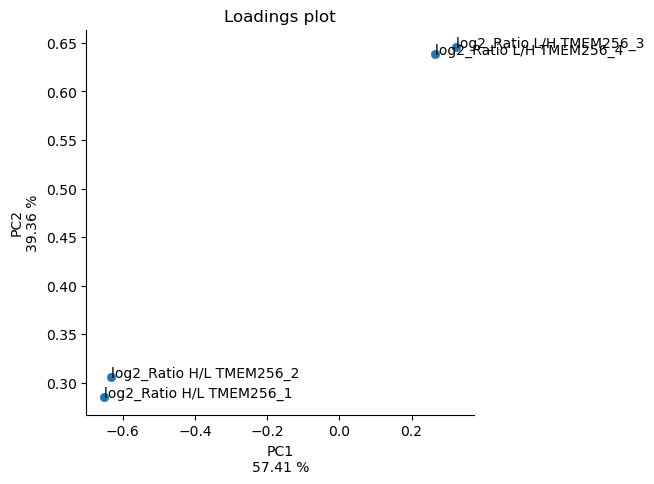

In [7]:
pca.loading_plot(labeling=True)

## Normalisation
### Median normalisation

Differences in sample treatment and/or loading can shift the ratios between replicates in a systematic fashion. This will impair downstream statistical analysis that tests if the separate protein groups behave similarly in all replicates.
Normalisation corrects for these systematic effects by shifting the log ratio distributions.
To account for loading differences, we start with a median normalisation that shifts the medians of the repliates to the median of medians between replicates.

In [8]:
# median normalisation
mnorm_cols = []
for col in log_ratio_cols:
    # calculate the correction factor
    median_shift = pg[col].median() - pg[log_ratio_cols].median().median()
    # generate a new column name for the median-corrected ratios
    new_col = col + "_mnorm"
    mnorm_cols.append(new_col)
    # apply the correction and store in the new column
    pg[new_col] = pg[col] - median_shift

mnorm_cols

['log2_Ratio H/L TMEM256_1_mnorm',
 'log2_Ratio H/L TMEM256_2_mnorm',
 'log2_Ratio L/H TMEM256_3_mnorm',
 'log2_Ratio L/H TMEM256_4_mnorm']

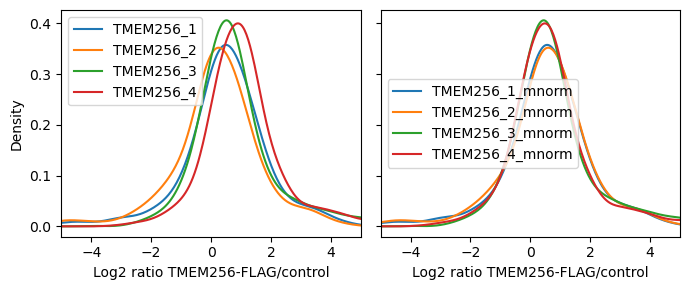

In [9]:
# visualisation of the effect of median normalisation
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharex=True, sharey=True)

# plot kernel density plots to show the different distributions
pg[log_ratio_cols].plot(kind="kde", ax=axs[0])
pg[mnorm_cols].plot(kind="kde", ax=axs[1])

# shorten labels
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    labels = [x.split(" ")[-1] for x in labels]

    ax.legend(handles, labels)
    ax.set_xlabel("Log2 ratio TMEM256-FLAG/control")
    ax.set_xlim((-5, 5))

# nice figures and save result
plt.tight_layout()
plt.savefig("apms_fig2.pdf")
plt.show()

### Cyclic LOESS normalisation 
In addition to median normalisation, the data sometimes requires additional normalisation to produce meaningful results. In this case, the two replicates with the label switch are visually different from the other two replicates which is an effect we are not interested in investigating in the study.
To reduce the labeling-bias, we use a smoothing normalisation, cyclic LOESS (local weighted smooting, see https://towardsdatascience.com/loess-373d43b03564 for an introduction). We employ the LOESS normalisation implemented in the R package limma (https://www.rdocumentation.org/packages/limma/versions/3.28.14/topics/normalizeCyclicLoess).

In [10]:
# LOESS normalisation
pg, loess_cols = pp.cyclic_loess(pg, mnorm_cols, return_cols=True)

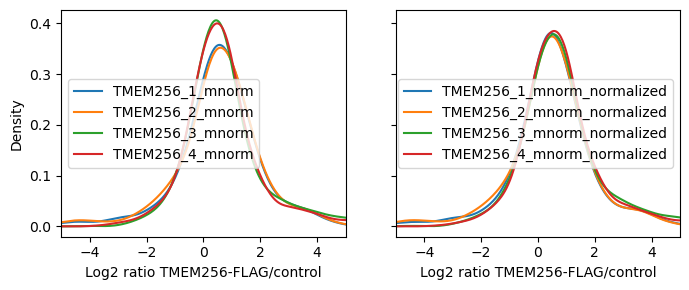

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharex="all", sharey="all")

# kernel density plots
pg[mnorm_cols].plot(kind="kde", ax=axs[0])
pg[loess_cols].plot(kind="kde", ax=axs[1])

# shorten labels
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    labels = [re.split(" |\.", x)[-1] for x in labels]

    ax.legend(handles, labels)
    ax.set_xlabel("Log2 ratio TMEM256-FLAG/control")
    ax.set_xlim((-5, 5))

plt.tight_layout()
plt.savefig("apms_fig3.pdf")
plt.show()

To check again if the normalisation has removed the label-switch effect, we perform another PCA.
As you can see even though the global differences between the replicates are greatly reduced, the label-switch effect is still visible.

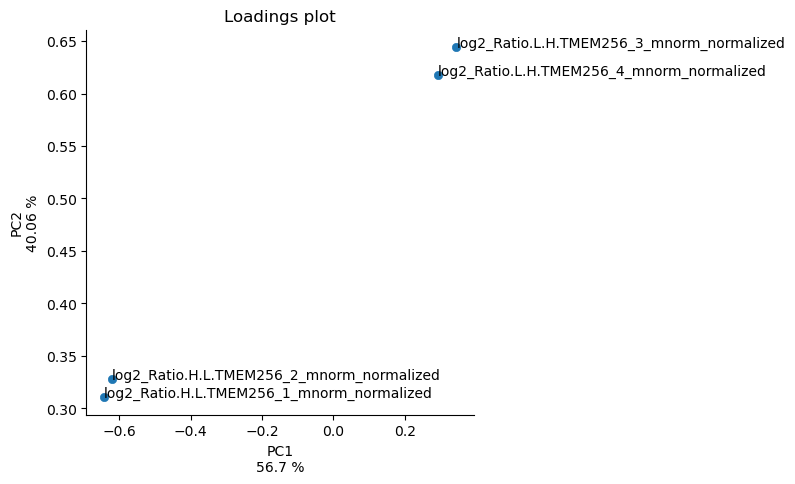

In [12]:
pca = ana.AutoPCA(pg[loess_cols], clabels=loess_cols)
pca.loading_plot(labeling=True)

## Batch effect correction
The label-switch effect is a batch effect that can either be corrected or included in the statistical analysis.
Here we demonstrate a simple batch effect correction that subtracts half the difference between the two groups from the original ratios.

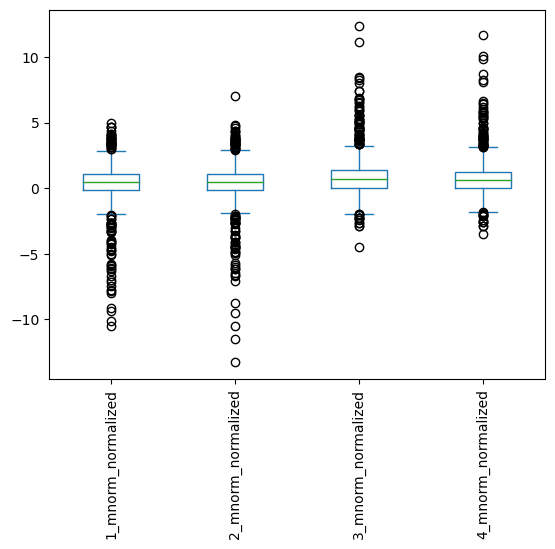

In [13]:
pg[loess_cols].plot(kind="box", vert=True)
# rotate the x-axis labels
plt.xticks(rotation=90)
# shorten labels to the last 18 chars
plt.gca().set_xticklabels([x[-18:] for x in pg[loess_cols].columns])
plt.show()

In [14]:
def simple_batch_effect_correction(row, labels_group_1, labels_group_2):
    # calculate the mean of the two groups
    mean_group_1 = row[labels_group_1].mean()
    mean_group_2 = row[labels_group_2].mean()

    # calculate the difference
    diff = mean_group_1 - mean_group_2

    # subtract half the difference from the original ratios
    row[labels_group_1] = row[labels_group_1].sub(diff / 2)
    row[labels_group_2] = row[labels_group_2].add(diff / 2)

    return row


pg[loess_cols] = pg[loess_cols].apply(
    simple_batch_effect_correction, args=(loess_cols[:2], loess_cols[2:]), axis=1
)

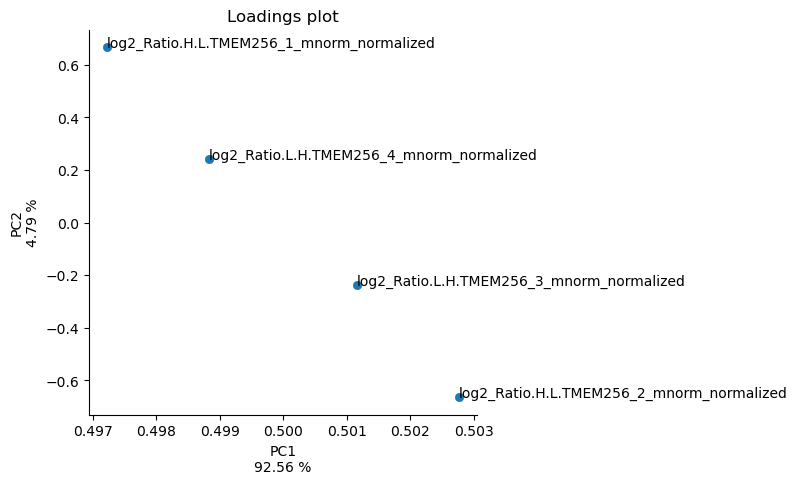

In [15]:
pca = ana.AutoPCA(pg[loess_cols], clabels=loess_cols)
pca.loading_plot(labeling=True)

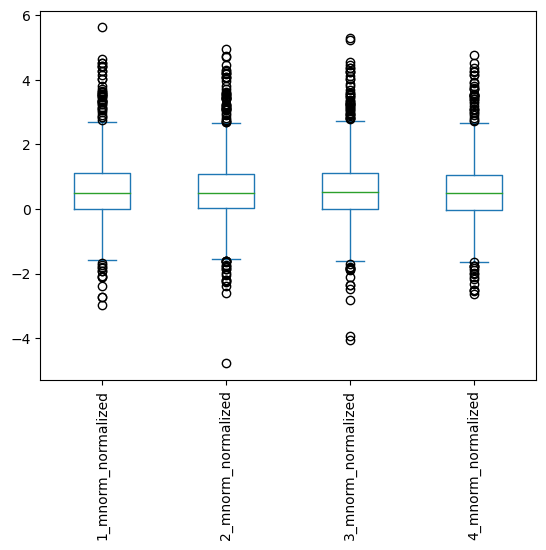

In [16]:
pg[loess_cols].plot(kind="box", vert=True)
# rotate the x-axis labels
plt.xticks(rotation=90)
# shorten labels to the last 18 chars
plt.gca().set_xticklabels([x[-18:] for x in pg[loess_cols].columns])
plt.show()

## Statistical analysis
For statistical analysis, conventional t-tests have long been used (and are still used today). The pre-processed, normalised ratio distribution should produce a similar result when analysed with a t-test.
Here we want ot focus on more recent linear models for statistical analyiss.
### Linear models
In contrast to conventional t-tests, linear models take global patterns into account and can include information for example about label-switches.
As we have previously normalised the ratios, we can use a linear fit as the model rendering the result very similar to a t-test.

In [17]:
pg = ana.limma(pg, loess_cols, cond="_limma")

LIMMA: Assuming a one sample test


## Visualisation
The most common visulisation for quantitiatve AP-MS results is a volcano plot that depicts the average enrichment on the x-axis vs. the statistical significance of the enrichment on the y-axis.
Protein groups falling into the upper right quadrant are significantly enriched and are promising targets for biological validation
### Volcano plot

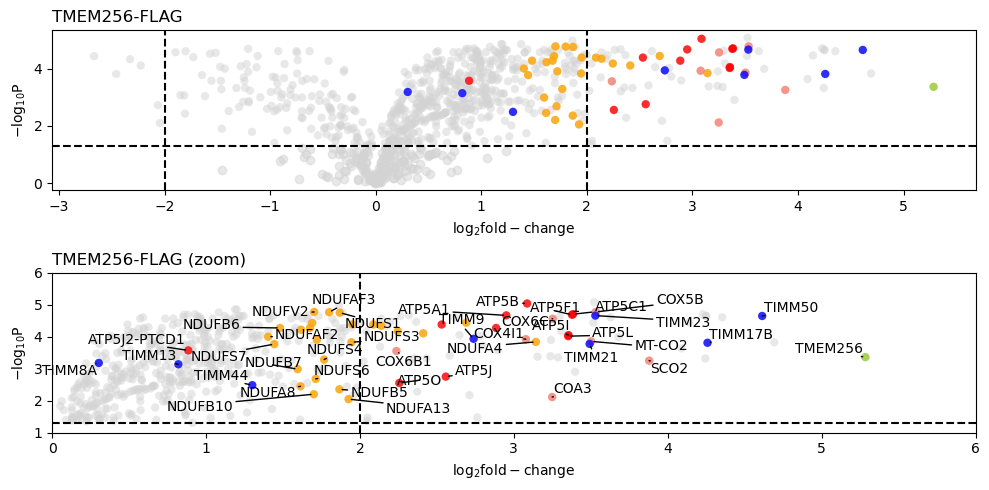

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

# this is the index of the bait protein
highlight_bait = pg[pg["Gene names"].str.contains("TMEM256", na=False)].index

# these are proteins associated with specififc biological processes that we want top hightlight in the plot
complex1 = ["NDUF"]
complex4 = ["COA3", "MT-CO2", "SCO2", "COX4", "COX5B", "COX6"]
complex5 = ["ATP5"]

highlight_complex1 = pg[
    pg["Gene names"].str.contains("|".join(complex1), na=False)
].index
highlight_complex4 = pg[
    pg["Gene names"].str.contains("|".join(complex4), na=False)
].index
highlight_complex5 = pg[
    pg["Gene names"].str.contains("|".join(complex5), na=False)
].index

protein_import = ["TIMM"]
highlight_import = pg[
    pg["Gene names"].str.contains("|".join(protein_import), na=False)
].index

# this are the appearances of the three groups
kwargs_highlight = [
    {"color": "orange", "edgecolor": "none"},
    {"color": "salmon", "edgecolor": "none"},
    {"color": "red", "edgecolor": "none"},
    {"color": "blue", "edgecolor": "none"},
    {"color": "yellowgreen", "edgecolor": "none"},
]

# this wrapper function produces the actual volcano plot
vis.volcano(
    pg,
    log_fc_colname="logFC_limma",  # colname from which the x values are taken
    p_colname="adj.P.Val_limma",  # same for the y values
    log_fc_thresh=2,  # a threshold of 4-fold enrichment is typically chosen
    annotate=None,  # dont label the overview plot
    kwargs_both_sig={"color": "lightgrey", "edgecolor": "none"},
    kwargs_p_sig={"color": "lightgrey", "edgecolor": "none"},
    kwargs_log_fc_sig={"color": "lightgrey", "edgecolor": "none"},
    show_legend=False,
    highlight=[
        highlight_complex1,
        highlight_complex4,
        highlight_complex5,
        highlight_import,
        highlight_bait,
    ],
    kwargs_highlight=kwargs_highlight,
    ax=axs[0],
    show_caption=False,
    title="TMEM256-FLAG",
)

# this is a subset of proteins falling into the upper right quadrant
zoom = pg[(pg["logFC_limma"] > 0) & (pg["adj.P.Val_limma"] < 0.05)]

# these are the same highlight indices but now for the zoomed subset
highlight_complex1 = zoom[
    zoom["Gene names"].str.contains("|".join(complex1), na=False)
].index
highlight_complex4 = zoom[
    zoom["Gene names"].str.contains("|".join(complex4), na=False)
].index
highlight_complex5 = zoom[
    zoom["Gene names"].str.contains("|".join(complex5), na=False)
].index

highlight_import = zoom[
    zoom["Gene names"].str.contains("|".join(protein_import), na=False)
].index

# this is the zoomed volcano plot
vis.volcano(
    zoom,
    log_fc_colname="logFC_limma",
    p_colname="adj.P.Val_limma",
    log_fc_thresh=2,
    annotate="highlight",  # annotate the highlighted proteins
    kwargs_both_sig={"color": "lightgrey", "edgecolor": "none"},
    kwargs_p_sig={"color": "lightgrey", "edgecolor": "none"},
    kwargs_log_fc_sig={"color": "lightgrey", "edgecolor": "none"},
    show_legend=False,
    highlight=[
        highlight_complex1,
        highlight_complex4,
        highlight_complex5,
        highlight_import,
        highlight_bait,
    ],
    kwargs_highlight=kwargs_highlight,
    ax=axs[1],
    show_caption=False,
    annotate_colname="Gene names first",  # use the Gene names first column for the annotation
    title="TMEM256-FLAG (zoom)",
)

axs[1].set_xlim(0, 6)
axs[1].set_ylim(1, 6)

plt.tight_layout()

plt.savefig("apms_fig4.pdf")
plt.show()